# Тематическое разделение групп ВК

**Описание задачи:** разбить группы ВК на тематические области по описанию

**Исходные данные:** датасет с описанием групп ВК и ручной разметкой предметной области

**Формат решения:**   
Разделить датасет на тематические группы двумя способами
1) DecisionTreeClassifier. Проверка точности (метрика f1_score)  
2) Примените алгоритмов тематического моделирования. 

### Оглавление
[1. Загрузка и изучение данных](#id-section1__)  
[1.1. Открываем файл с данными](#id-section1.1.__)  
[1.2. Изучаем общую информацию](#id-section1.2.__)   
[2. Разделение датасета на тематические группы](#id-section2__)  
[2.1. Предобработка данных](#id-section2.1.__)  
[2.2. DecisionTreeClassifier](#id-section2.2.__)  
[2.2.1. CountVectorizer](#id-section2.2.1.__)  
[2.2.2. Tfidfvectorizer](#id-section2.2.2.__)  
[2.3. Тематическое моделирование (алгоритм Latent Dirichlet Allocation)](#id-section2.3.__) 


### Общие функции для работы 

In [1]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords
nltk.download('all')
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



import multiprocessing
from sklearn.decomposition import LatentDirichletAllocation

!pip install pymorphy2
import pymorphy2
import string

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Лена\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Лена\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Лена\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Лена\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\Лена\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

<div id='id-section1__'/>

## 1. Загрузка и изучение данных

<div id='id-section1.1.__'/>

### 1.1. Открываем файл с данными 

In [38]:
df = pd.read_csv('groups.csv',';').drop('Unnamed: 4',axis = 1)
classes = {class_:i for i, class_ in enumerate(df['Предмет'].unique())}
df['label'] = df['Предмет'].replace(classes)

In [39]:
df

,id,URL,Название,Предмет,label
0,72894053,https://vk.com/club72894053,Биология: материалы к олимпиадам и экзаменам,биология,0
1,47693493,https://vk.com/club47693493,Биология+химия-easy;) c Aleksandra LearnBiolog...,биология,0
2,37948240,https://vk.com/club37948240,Биология,биология,0
3,109143834,https://vk.com/club109143834,B.o.S - Биология Спорта,биология,0
4,32140813,https://vk.com/club32140813,Углублённый Биолог,биология,0
...,...,...,...,...,...
1784,43732804,https://vk.com/club43732804,Кодексы и законы РФ,юриспруденция,18
1785,28799949,https://vk.com/club28799949,Закон.ру,юриспруденция,18
1786,42832964,https://vk.com/club42832964,Колледж АлтГУ,вуз,19
1787,40575907,https://vk.com/club40575907,КиберЛенинка,наука,20


<div id='id-section1.2.__'/> 

### 1.2. Изучаем общую информацию

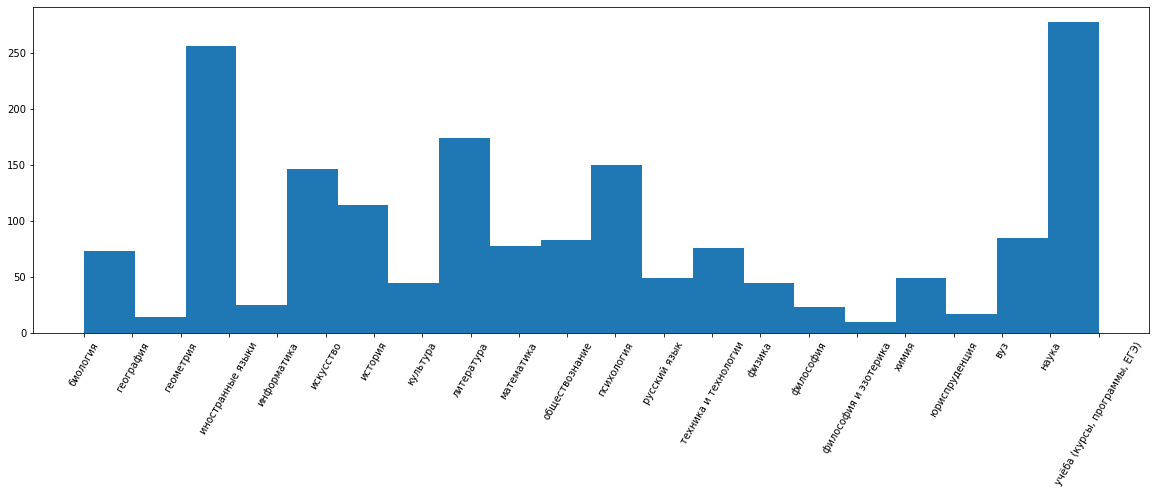

In [4]:
#### Нарисуем pie диограмму\гистограмму на основе колнки предметов
plt.figure(figsize=(20,6))
plt.hist(df['Предмет'], bins= 20)    
plt.xticks(rotation=60)
plt.show()



<AxesSubplot:ylabel='Предмет'>

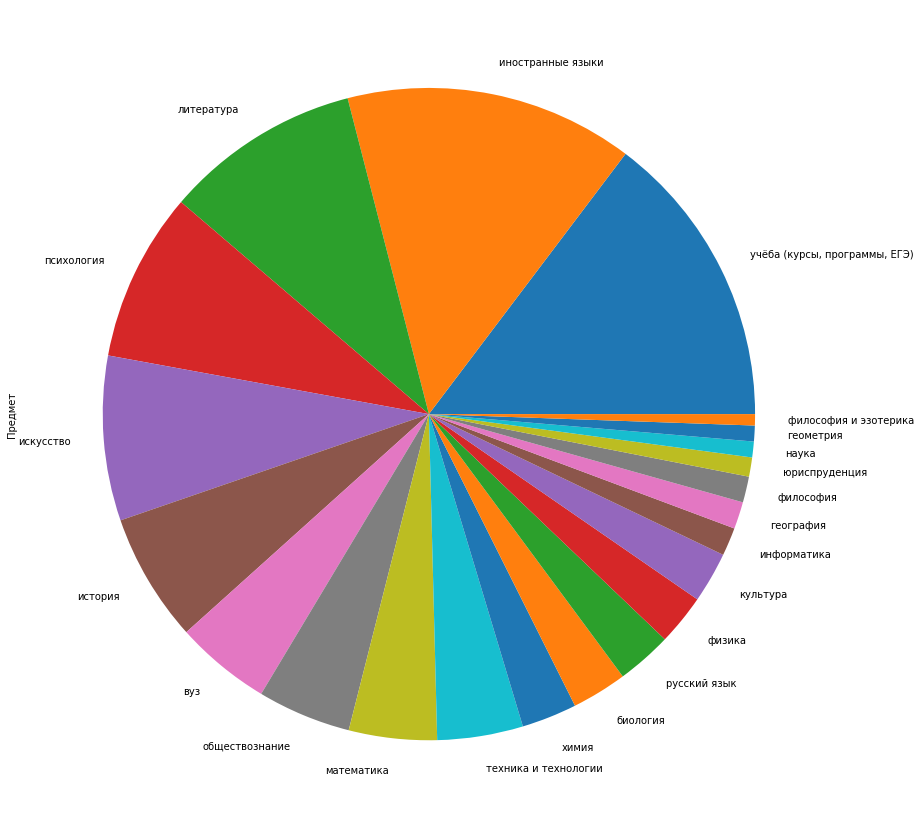

In [5]:
df['Предмет'].value_counts().plot(kind='pie', figsize=(15, 15))

In [6]:
df['label'].value_counts()

21    263
3     256
8     174
11    150
5     146
6     114
19     85
10     83
9      78
13     76
12     49
17     49
0      49
14     45
7      45
4      25
1      24
15     23
18     17
2      14
20     14
16     10
Name: label, dtype: int64

In [7]:
# Посмотрим среднюю длинну строк в колонке "Название"
count_words = lambda x: len(x.split()) #создаем функцию для поиска количества слов в колонке название

def count_words(x):
  return len(x.split())

In [8]:
df['count_words'] = df['Название'].apply(count_words) # генерируем колонку с количеством слов

In [9]:
df['count_words'].mean() # ищем среднее количество

3.777529346003354

<div id='id-section2__'/>

## 2. Разделение датасета на тематические группы 

<div id='id-section2.1.__'/>

### 2.1. Предобработка данных 

In [40]:
#Стеммирование колонки колонки 'Название', очистка от стоп слов, пунктуации
import string
punctuations = list(string.punctuation) # создаем переменную для пунктуации

# set нужен для того, чтобы поиск по словам был быстрее (потребуется позже)
from nltk.corpus import stopwords

ru_stop_words = set(stopwords.words('russian')) #создаем переменную для стоп слов


stemmer_ru = SnowballStemmer("russian") # создаем стеммер


def text_processing(text, stemmer, stop_words, punct):
    """принимает на вход предложение и возвращает леммы токенов предложения, фильтруя по стоп словам и удаляя знаки пунктуации"""
    words = word_tokenize(text.lower()) # С помощью токенизации разбиваем текст на токены 
    words = [word for word in words if word not in ru_stop_words] # Удаляем стопслова
    words = [word for word in words if word not in punct] # Удаляем знаки пунктуации
    
    words = [stemmer.stem(word) for word in words] # стеммируем каждое слово
    #words = [morph_analyzer.parse(word)[0].normalized.word for word in words] # лемматизируем каждое слово
    new_text = ' '.join(words)

    return new_text

func = lambda x: text_processing(x, stemmer_ru, ru_stop_words, punctuations)

df['Стеммированная колонка'] = df['Название'].apply(func) # генерируем стеммированную колонку, очищенную от стопслов и пунктуации

In [11]:
df

,id,URL,Название,Предмет,label,count_words,Стеммированная колонка
0,72894053,https://vk.com/club72894053,Биология: материалы к олимпиадам и экзаменам,биология,0,6,биолог материал олимпиад экзамен
1,47693493,https://vk.com/club47693493,Биология+химия-easy;) c Aleksandra LearnBiolog...,биология,0,4,биология+химия-еас c aleksandra learnbiology
2,37948240,https://vk.com/club37948240,Биология,биология,0,1,биолог
3,109143834,https://vk.com/club109143834,B.o.S - Биология Спорта,биология,0,4,b.o.s биолог спорт
4,32140813,https://vk.com/club32140813,Углублённый Биолог,биология,0,2,углублен биолог
...,...,...,...,...,...,...,...
1784,43732804,https://vk.com/club43732804,Кодексы и законы РФ,юриспруденция,18,4,кодекс закон рф
1785,28799949,https://vk.com/club28799949,Закон.ру,юриспруденция,18,1,закон.р
1786,42832964,https://vk.com/club42832964,Колледж АлтГУ,вуз,19,2,колледж алтг
1787,40575907,https://vk.com/club40575907,КиберЛенинка,наука,20,1,киберленинк


<div id='id-section2.2.__'/>

### 2.2. DecisionTreeClassifier 

In [41]:
#Разобьем выборку на train и test, a также создадим перемменную all_text
train_text, test_text = train_test_split(df['Стеммированная колонка'], test_size=0.25, random_state=42)
train_labels, test_labels = train_test_split(df['label'], test_size=0.25, random_state=42)
all_text = pd.concat([train_text, test_text])

<div id='id-section2.2.1.__'/>

#### 2.2.1. CountVectorizer

In [32]:
# Учим word_vectorizer на всех текстах, а трансформируем отдельно train и test
word_vectorizer = CountVectorizer()

word_vectorizer.fit(all_text)

train_word_features_vector = word_vectorizer.transform(train_text)
test_word_features_vector = word_vectorizer.transform(test_text)

In [33]:
# Обучаем модель на основе word_vectorizer
clf = DecisionTreeClassifier(random_state=42)
clf.fit(train_word_features_vector, train_labels)
preds_train = clf.predict(train_word_features_vector)
preds_test = clf.predict(test_word_features_vector)
#проверяем точность
f1_score(test_labels, preds_test, average='micro') 

0.7678571428571429

In [34]:
#Обучаем модель с помощью кросс-валидации (на word_vectorizer)
clf=DecisionTreeClassifier(random_state=0)
#проверяем точность
scores = np.mean(cross_val_score(clf,train_word_features_vector, train_labels, cv=5, scoring='f1_macro'))
scores

0.7130911184607888

<div id='id-section2.2.2.__'/>

#### 2.2.2. TfidfVectorizer

In [42]:
# Учим word_vectorizer на всех текстах, а трансформируем отдельно train и test

word_vectorizer = TfidfVectorizer()

word_vectorizer.fit(all_text)

train_word_features_tf_idf = word_vectorizer.transform(train_text)
test_word_features_tf_idf = word_vectorizer.transform(test_text)


clf = DecisionTreeClassifier(random_state=42)
clf.fit(train_word_features_tf_idf, train_labels)
preds_train = clf.predict(train_word_features_tf_idf)
preds_test = clf.predict(test_word_features_tf_idf)


f1_score(test_labels, preds_test, average='micro')

0.75

In [43]:
# Обучаем модель с помощью кросс-валидации (на TF-IDF)
clf=DecisionTreeClassifier(random_state=0)
# Проверяем точность
scores = np.mean(cross_val_score(clf,train_word_features_tf_idf, train_labels, cv=5, scoring='f1_macro'))
scores

0.7191845761256657

<div id='id-section2.3.__'/>

## 2.3. Тематическое моделирование (алгоритм Latent Dirichlet Allocation (LDA))

In [44]:
morph_analyzer = pymorphy2.MorphAnalyzer() # Создаем объект стеммера
ru_stop_words = set(stopwords.words('russian')) # Подгружаем список стоп слов из модуля stopwords библиотеки nltk 
punctuations = list(string.punctuation)

def text_processing(text, morph_analyzer, stop_words, punct):
    """принимает на вход предложение и возвращает леммы токенов предложения, фильтруя по стоп словам и удаляя знаки пунктуации"""
    words = word_tokenize(text.lower()) # С помощью токенизации разбиваем текст на токены 
    words = [word for word in words if word not in stop_words] # Удаляем стопслова
    words = [word for word in words if word not in punct] # Удаляем знаки пунктуации
    words = [morph_analyzer.parse(word)[0].normalized.word for word in words] # лемматизируем каждое слово
    words = ' '.join(words)

    return words

# генерируем колонку lemmatized_text
df['lemmatized_text'] = df['Название'].apply(lambda x: text_processing(x, morph_analyzer, ru_stop_words, punctuations)) # с помощью метода apply прогоняем значения колонки text через нашу функцию обработки text_processing
df.head()

,id,URL,Название,Предмет,label,Стеммированная колонка,lemmatized_text
0,72894053,https://vk.com/club72894053,Биология: материалы к олимпиадам и экзаменам,биология,0,биолог материал олимпиад экзамен,биология материал олимпиада экзамен
1,47693493,https://vk.com/club47693493,Биология+химия-easy;) c Aleksandra LearnBiolog...,биология,0,биология+химия-еас c aleksandra learnbiology,биология+химия-easy c aleksandra learnbiology
2,37948240,https://vk.com/club37948240,Биология,биология,0,биолог,биология
3,109143834,https://vk.com/club109143834,B.o.S - Биология Спорта,биология,0,b.o.s биолог спорт,b.o.s биология спорт
4,32140813,https://vk.com/club32140813,Углублённый Биолог,биология,0,углублен биолог,углублённый биолог


In [19]:
texts = df['lemmatized_text'] # TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
term_document_matrix = vectorizer.fit_transform(texts)

In [20]:
NUM_AVAILABLE_CPU = multiprocessing.cpu_count() # указываем кол-во ядер, чтобы оптимизировать вычисления

print(f"свободно {NUM_AVAILABLE_CPU} ядер для вычислений")

lda = LatentDirichletAllocation(n_components=10, # 
                 max_iter=10,
                 n_jobs=NUM_AVAILABLE_CPU-1,
                 learning_method='batch',
                 verbose=2)

lda.fit(term_document_matrix)

свободно 4 ядер для вычислений


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


LatentDirichletAllocation(n_jobs=3, verbose=2)

In [21]:
pd.DataFrame(lda.transform(term_document_matrix)) # преобразование данных с помощью lda

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


,0,1,2,3,4,5,6,7,8,9
0,0.041509,0.041509,0.041509,0.041509,0.041509,0.041509,0.041509,0.358811,0.309120,0.041509
1,0.041428,0.041428,0.041428,0.041428,0.041428,0.041428,0.041428,0.327336,0.341239,0.041428
2,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000
3,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000
4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
...,...,...,...,...,...,...,...,...,...,...
1784,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000
1785,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1786,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1787,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


In [22]:
df['lda_topic'] = lda.transform(term_document_matrix).argmax(axis = 1)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


In [23]:
df['lda_topic'].value_counts()

0    568
5    275
8    174
7    147
9    141
3    140
1    120
2     92
4     77
6     55
Name: lda_topic, dtype: int64

In [24]:
# функция для отрисовки тематик и ключевых слов, входящих в нее

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

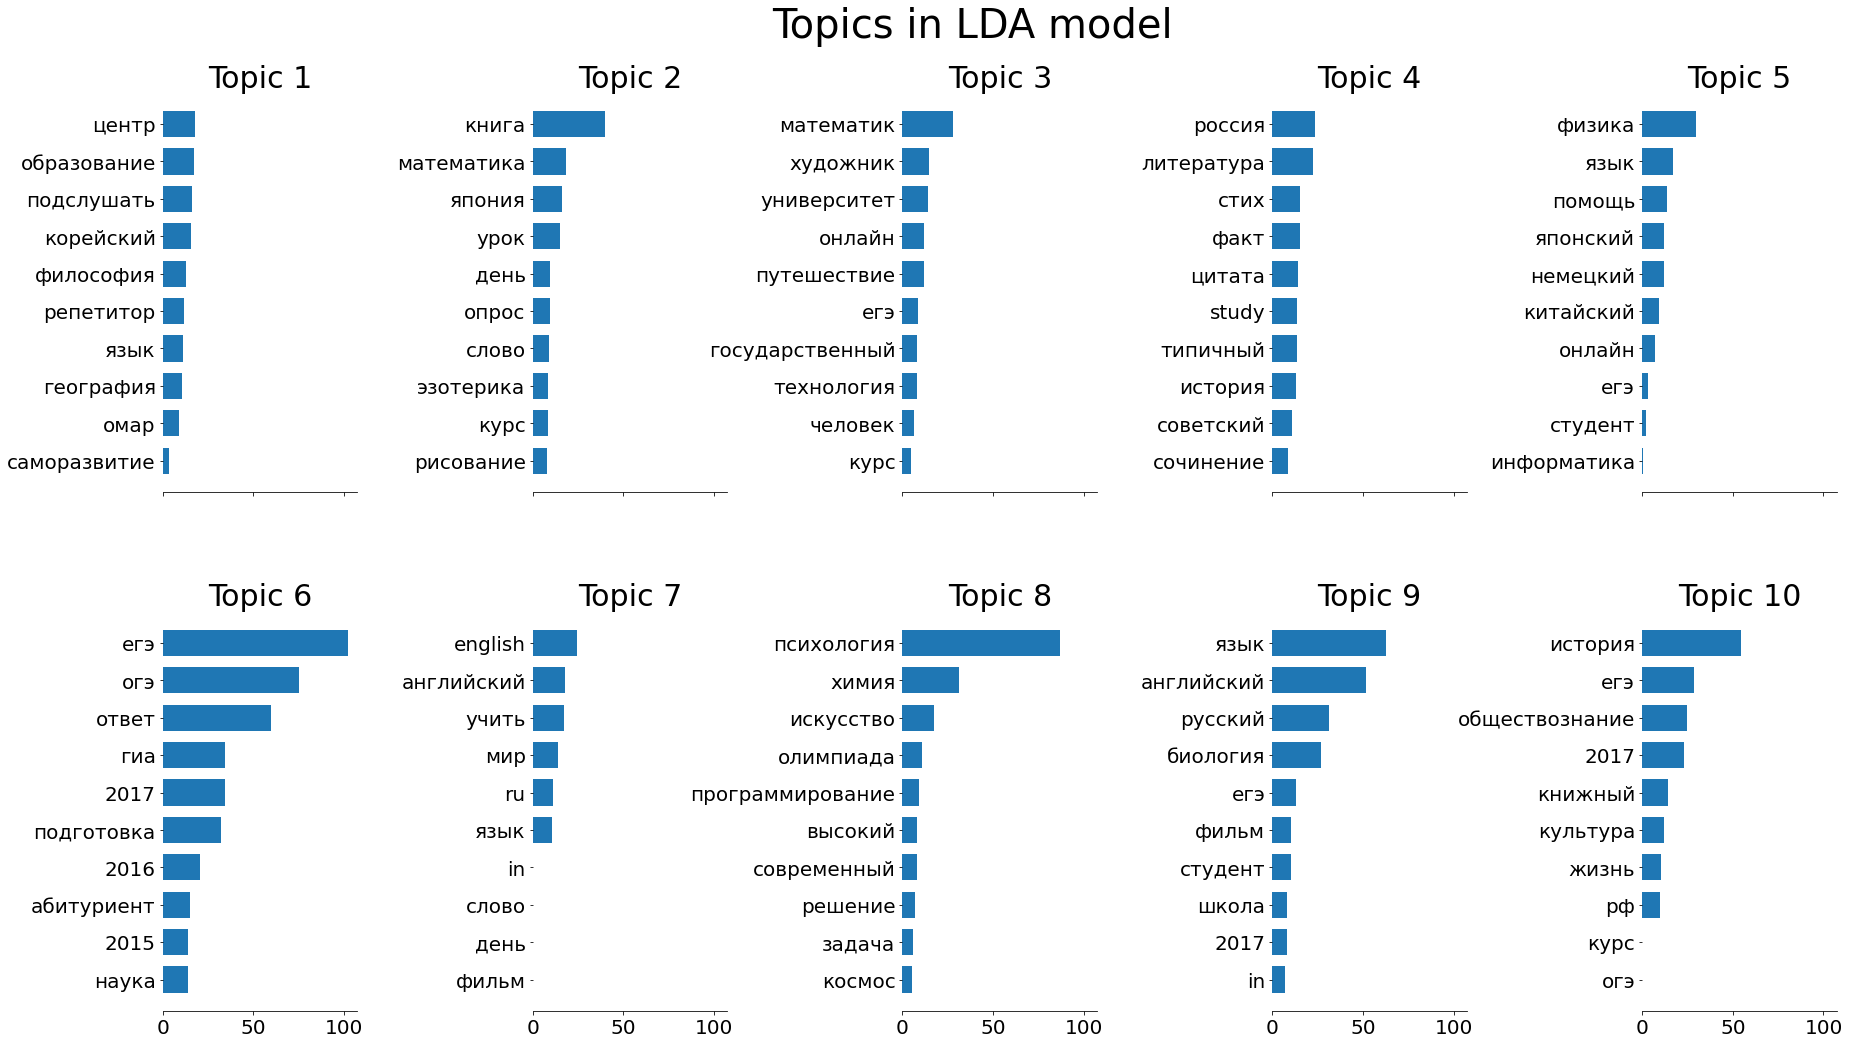

In [25]:
terms = vectorizer.get_feature_names()
n_top_words = 10

plot_top_words(lda, terms, n_top_words, 'Topics in LDA model')